# Conifer doesn't allow for fine optimization of the precision level for each variable
## this notebook computes the average number of look up table for a BDT node at a given precision level and tree depth in order to build a proxy

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib

import imblearn
from sklearn.model_selection import train_test_split
import collections
from sklearn.metrics import roc_curve, auc
import conifer
import time
from scipy.special import expit
import datetime
import random

In [2]:
data_dir='/grid_mnt/vol_home/llr/cms/hakimi/HGCAL/New_vars' # output from alternative_var.ipynb
# select signal and background (not improtant for this estiamtion, I used elec vs PU)
signal='elec' 
bkg = 'PU' # the choice of background has no impact on results
df_sig= pd.read_csv(data_dir+'/{}_df.csv'.format(signal), low_memory=True)
df_bkg=pd.read_csv(data_dir+'/{}_df.csv'.format(bkg), low_memory=True)
#join dfs
data=df_sig.append(df_bkg)

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [8]:

if bkg == 'pions':
    features =['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_5', 'ebm1', 'Emax_4R', 'hbm', 'firstHcal_1', 'reverse_ebm1']
    
        
elif bkg == 'PU':
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                'firstHcal_5', 'Emax_4R', 'ebm1', 'Emax_2R', 'firstHcal_1', 'Emax_5']
    
elif bkg == 'QCD':
    features=  ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT','ebm1', 'Emax_4R',
                'reverse_ebm1', 'first_2', 'Emax_2R', 'Emax_5', 
                ]

# preprocessing and balancing

In [3]:
#chose signal and background
#weight calc
data['signal']= 5 #initialize signal columns
data['weight']=0 #initialize weight
data['signal'][data['sample']==signal]= 1
data['signal'][data['sample']!=signal] = 0

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
#compute weights to balance signal/bkg

tot_event=len(data)
sig_event=len(data[data['signal']==1])
bkg_event=len(data[data['signal']==0])
ws=tot_event/sig_event
wb=tot_event/bkg_event

data['weight'][data['signal']==0]=wb
data['weight'][data['signal']==1]=ws

print('signal weight = {}, bkg weight ={}'.format(ws, wb))

In [9]:
#preprocess data for BDT training
X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']],
                                                    test_size=0.2,random_state=42)
train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
y_train_untouched=y_train
X_train_untouched=X_train



#balancing (combination of SMOTE + underbalance, better than reweight)
over_ratio = 0.2 
under_ratio = 0.5 
over=imblearn.over_sampling.SMOTE(sampling_strategy=over_ratio, random_state=42)#oversample the minor class up to X% of major class
under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio, random_state=42)#undersample the major class up to 1/X times the minor class
X_train, y_train=over.fit_resample(X_train,y_train['signal'])
X_train, y_train=under.fit_resample(X_train, y_train)
y_train=pd.DataFrame(y_train)
y_train['weight']=1


# Quantization
### quantize variables at given precision in order to use on FPGA

In [15]:
#compute the maximum precision level: discrete variables are treated in a diffeent way

def maxbits(feat, maxbit):
    if feat.dtype == 'float64':
        return maxbit
    elif feat.dtype =='int64':
        nval = len(np.unique(feat))
        print(nval)
        for i in range(1,maxbit) : 
            if 2**i >= nval: return(i)
        return(i)

In [17]:
#change discrete functions type to int
discrete_cols = ['cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer' ]
data[discrete_cols]=data[discrete_cols].astype('int64')


In [20]:
# quantization

def quantize(feat, nbits, method, fmin, fmax): #feat is the feature to quantize, nbits the number of bits, method: 'uniform' or 'percentile'
    nbins= 2**nbits
    if feat.dtype == 'float64':
        method = method
    elif feat.dtype == 'int64':
        method = 'uniform'
    if method == 'uniform':
        bins=np.linspace(fmin, fmax, nbins+1)
    elif method == 'percentile':
        bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
    else :
        print('Error: Invalid method')
        return
    
    
    #print(feat.dtype,nbits, method)
    return np.digitize(feat, bins, right=True)

#bitmap quantization is computed by fusing X layers
def quantize_ebm0(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.ebm0)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm


def quantize_ebm1(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.ebm1)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_hbm(x,nb):
    qbm=[]
    nlay=21
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.hbm)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,nlay,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverse_ebm0(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.reverese_ebm0)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverse_ebm1(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm =int(x.reverese_ebm1)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverese_hbm(x,nb):
    qbm=[]
    nlay=21
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.reverse_hbm)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,nlay,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm

# FPGA implementaiton

In [25]:
#function to remove folder
import shutil
def remove_folder(path):
    # check if folder exists
    if os.path.exists(path):
         # remove if exists
         shutil.rmtree(path)
    else:
         # throw your exception to handle this special scenario
         raise XXError("your exception") 

### training function

In [27]:

base_dir=os.getcwd()
def train_BDT(precision, depth, boost_rounds, iteration):
    print("precision={}, depth= {}, rounds={}".format( precision, depth, boost_rounds))
    timer=time.time()
    nfeat=len (data[features].columns)
    param['eta']= 0.01 #fixed learning rate
    param['max_depth']=depth
    num_boost_round=boost_rounds

    
    qtrain=pd.DataFrame()
    qtest=pd.DataFrame()
    #qtest['signal']=y_test['signal']
    feat_kept=features.copy()
    tot_bits=0
    
    #quantize features to given precision level
    for i,feat in enumerate(X_train.columns):
        if x[i]==0: #drop feat
            #print("dropping {} from {}".format(feat, feat_kept))
            feat_kept.remove(feat)
        elif 'bm' not in 'feat':
            fmin, fmax= X_train[feat].min(), X_train[feat].max()
            qtrain[feat]=quantize(X_train[feat], precision, 'uniform', fmin, fmax)
            qtest[feat]=quantize(X_test[feat],precision, 'uniform', fmin, fmax)
            tot_bits += x[i]
        elif feat == 'ebm0':
            qtrain[feat]=X_train.apply(quantize_ebm0, nb = precision, axis=1)
            qtest[feat]=X_test.apply(quantize_ebm0, nb = precision, axis=1)
            nlay=14
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
        elif feat == 'ebm1':
            qtrain[feat]=X_train.apply(quantize_ebm1, nb = precision, axis=1)
            qtest[feat]=X_test.apply(quantize_ebm1, nb = precision, axis=1)
            nlay=14
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
        elif feat == 'hbm':
            qtrain[feat]=X_train.apply(quantize_hbm, nb = precision, axis=1)
            qtest[feat]=X_test.apply(quantize_hbm, nb = precision, axis=1)
            nlay=21
            bits=nlay/int(np.ceil(nlay/x[i]))
            tot_bits += nlay/int(np.ceil(nlay/x[i]))
        elif feat == 'reverse_ebm0':
            qtrain[feat]=X_train.apply(quantize_reverse_ebm0, nb = precision, axis=1)
            qtest[feat]=X_test.apply(quantize_reverse_ebm0, nb = precision, axis=1)
            nlay=14
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
        elif feat == 'reverse_ebm1':
            qtrain[feat]=X_train.apply(quantize_reverse_ebm1, nb = precision, axis=1)
            qtest[feat]=X_test.apply(quantize_reverse_ebm1, nb = precision, axis=1)
            nlay=14
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
        elif feat == 'reverse_hbm':
            qtrain[feat]=X_train.apply(quantize_reverse_hbm, nb = precision, axis=1)
            qtest[feat]=X_test.apply(quantize_reverse_hbm, nb = precision, axis=1)
            nlay=21
            bits=nlay/int(np.ceil(nlay/x[i]))
            if bits > 0:
                tot_bits += bits
    print('quantize time ={:.2f}s'.format(time.time() - timer))
    qtest_unscaled=qtest.copy()

    #normalize inputs
    
    from sklearn import preprocessing
    feats=qtest.columns
    max_range=1-1/(2**precision)
    scaler = preprocessing.MinMaxScaler(feature_range=(0, max_range)) #need to cast to [0,1[ to discard the int bit for conifer quantization
    qtrain = scaler.fit_transform(qtrain)
    qtrain=pd.DataFrame(qtrain, columns=features)
    qtest = scaler.fit_transform(qtest)
    qtest=pd.DataFrame(qtest, columns=feats)
    


    train= xgb.DMatrix(data=qtrain.to_numpy(),label=y_train['signal'],  weight=y_train['weight']) 
    test= xgb.DMatrix(data=qtest.to_numpy(),label=y_test['signal'],) 
    #use gpu if available
    gpu=tf.test.is_gpu_available(
        cuda_only=False, min_cuda_compute_capability=None
    )
    if gpu==True:
        param['tree_method']='gpu_hist'

    #Now train and fit best parameters BDT
    eval_result = {}
    BDT = xgb.train(
        param,
        train,
        num_boost_round=num_boost_round,
        #feval = SoverB,
        evals=[(train, 'Train'),(test, "Test")],
        evals_result = eval_result,
        verbose_eval=None,
    )
    #compute predictions and ROC AUC
    pred= BDT.predict(test)
    
    fpr, tpr, threshold = roc_curve(y_test['signal'],pred, pos_label=1)
    fpr.sort()
    tpr.sort()
    roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    cut=0.8
    roc_thr=roc_test[roc_test['tpr']>0.8]
    if len(roc_thr)>3:
        f1= (-1)*auc(roc_thr['fpr'], roc_thr['tpr']) # negative to be a minimization
    else : 
        f1 = 0
    
    #compute number of splits in BDT
    f2= len(BDT.trees_to_dataframe()[BDT.trees_to_dataframe()['Feature']!='Leaf'])
    
    print('training duration = {:.2f}s'.format(time.time()-timer))
    timer=time.time()
    
    
    # Create a conifer config
    cfg = conifer.backends.vhdl.auto_config() #hls backend can fail, prefer vhdl
    # Set the output directory to something unique
    os.makedirs('hdlprojects', exist_ok=True)
    path='hdlprojects/prj_vhdl_{}_{}'.format(str(datetime.date.today()),iteration)
    if os.path.exists(path):
        remove_folder(path)
    cfg['OutputDir'] = path
    cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e' #VU13P
    #precision: # 'ap_fixed<{},{}>'.format(total, integer), since inputs are normalized between [0,1[, can use 0 bits for integer part
    cfg['Precision']='ap_fixed<{},{}>'.format(precision, 0) 
    #cfg['ScorePrecision']= 'ap_fixed<16,8>' # not in vhdl backend
    #cfg['ThresholdPrecision']= 'ap_fixed<16,8>' # not in vhdl backend
    #cfg['InputPrecision']= 'ap_fixed<16,8>' # not in vhdl backend
    cfg['ProjectName']= 'hgcal_vhdl'
    cfg['ClockPeriod']=3
    for key in cfg:
        print(key, ':', cfg[key])

    # Create and compile the model
    cnf_model = conifer.model(BDT, conifer.converters.xgboost,
                          conifer.backends.vhdl, cfg) #vhdl #xilixhls
    cnf_model.compile()
    y_hdl = expit(cnf_model.decision_function(qtest))
    qtest['y_hdl']=y_hdl
    qtest['y_xgb']=pred
    qtest_unscaled.to_csv(path+'/qtest_unscaled.csv') #for verification purpose
    qtrain.to_csv(path+'/qtrain.csv') #for verification purpose
    qtest.to_csv(path+'/qtest.csv')#for verification purpose
    BDT.save_model(path+'/model.model')
    
    #compute synthesized model roc auc
    fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),y_hdl, pos_label=1, sample_weight=y_test['weight'])
    tpr.sort()
    fpr.sort()
    roc_auc_hdl =auc(fpr, tpr)
    roc_hdl=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})

    roc_hdl_thr=roc_hdl[roc_hdl['tpr']>0.8]
    if len(roc_hdl_thr)>3:
        f5= (-1)*auc(roc_hdl_thr['fpr'], roc_hdl_thr['tpr']) # negative to be a minimization
    else : 
        f5 = 0
    
    cnf_model.build(csim=True)
    #read number of LUT used
    report= open(cfg['OutputDir'] + '/util.rpt', 'r')
    lines=report.readlines()
    #LUTS line 37, CLB line 42, CARRY8 line 45, bonded IOB line 102
    LUT=int(lines[37].split('|')[2]) #get number of LUT used for BDT
    f4=LUT #LUT
    print("synthesis time {:.2f}s".format(time.time() - timer))
    
    os.chdir(base_dir)
    #f1 = XGB model roc auc, f2 = number of splits in bdt, f4 = nb of LUT, f5 = synthesized roc auc
    return(depth, boost_rounds, precision, f1,f2,f4,f5)

## train the BDT models

In [ ]:

sampling=[]
results=pd.DataFrame(columns=['depth', 'rounds','precision',  'xgb eff', 'nb splits', 'nb LUT', 'hdl eff'])

# compute nb of LUT for different precisions, depth and number of rounds
for prec in range(1,16):
    for depth in range(2,6):
        for rounds in range(2,20,1):
            sampling.append([prec, depth, rounds])
            
for i,it in enumerate(sampling):
    print("Iter {}/{}".format(i+1, len(sampling)))
    current_res=train_BDT(it[0], it[1], it[2], i)
    #current_res=train_BDT(it, 2, 20, i, it)
    results=results.append(pd.Series(current_res, index=results.columns,), ignore_index=True)
    results.to_csv("conifer_opti.csv") # save at every step in case something happens
print('done')

Iter 1/648
precision=1, depth= 2, rounds=2
quantize time =0.15s
training duration = 0.35s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-20_0
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 141.57s
Iter 2/648
precision=1, depth= 2, rounds=3
quantize time =0.18s
training duration = 0.45s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-20_1
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 142.10s
Iter 3/648
precision=1, depth= 2, rounds=4
quantize time =0.22s
training duration = 0.56s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-20_2
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 141.63s
Iter 4/648
precision=1, depth= 2, rounds=5
quantize time =0.23s
training duration = 0.58s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_3
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-

quantize time =0.23s
training duration = 0.88s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_31
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 146.02s
Iter 33/648
precision=1, depth= 3, rounds=16
quantize time =0.22s
training duration = 0.92s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_32
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 147.27s
Iter 34/648
precision=1, depth= 3, rounds=17
quantize time =0.21s
training duration = 0.93s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_33
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 147.24s
Iter 35/648
precision=1, depth= 3, rounds=18
quantize time =0.21s
training duration = 1.00s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_34
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis ti

synthesis time 154.11s
Iter 64/648
precision=1, depth= 5, rounds=11
quantize time =0.22s
training duration = 0.85s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_63
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 155.08s
Iter 65/648
precision=1, depth= 5, rounds=12
quantize time =0.20s
training duration = 0.88s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_64
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 156.95s
Iter 66/648
precision=1, depth= 5, rounds=13
quantize time =0.19s
training duration = 0.94s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_65
Precision : ap_fixed<1,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 159.13s
Iter 67/648
precision=1, depth= 5, rounds=14
quantize time =0.22s
training duration = 1.00s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_66
Precision : ap_fixed<

quantize time =0.28s
training duration = 0.76s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_94
Precision : ap_fixed<2,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 142.13s
Iter 96/648
precision=2, depth= 3, rounds=7
quantize time =0.28s
training duration = 0.73s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_95
Precision : ap_fixed<2,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 141.79s
Iter 97/648
precision=2, depth= 3, rounds=8
quantize time =0.23s
training duration = 0.66s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_96
Precision : ap_fixed<2,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 142.16s
Iter 98/648
precision=2, depth= 3, rounds=9
quantize time =0.23s
training duration = 0.75s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_97
Precision : ap_fixed<2,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 

quantize time =0.23s
training duration = 1.10s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_125
Precision : ap_fixed<2,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 153.17s
Iter 127/648
precision=2, depth= 5, rounds=2
quantize time =0.21s
training duration = 0.48s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_126
Precision : ap_fixed<2,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 142.51s
Iter 128/648
precision=2, depth= 5, rounds=3
quantize time =0.22s
training duration = 0.54s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_127
Precision : ap_fixed<2,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 142.31s
Iter 129/648
precision=2, depth= 5, rounds=4
quantize time =0.23s
training duration = 0.62s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_128
Precision : ap_fixed<2,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesi

quantize time =0.30s
training duration = 0.91s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_156
Precision : ap_fixed<3,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 143.50s
Iter 158/648
precision=3, depth= 2, rounds=15
quantize time =0.26s
training duration = 0.85s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_157
Precision : ap_fixed<3,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 144.09s
Iter 159/648
precision=3, depth= 2, rounds=16
quantize time =0.30s
training duration = 0.93s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_158
Precision : ap_fixed<3,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 143.45s
Iter 160/648
precision=3, depth= 2, rounds=17
quantize time =0.25s
training duration = 0.93s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_159
Precision : ap_fixed<3,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synth

quantize time =0.23s
training duration = 0.78s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_187
Precision : ap_fixed<3,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 147.32s
Iter 189/648
precision=3, depth= 4, rounds=10
quantize time =0.23s
training duration = 0.84s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_188
Precision : ap_fixed<3,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 148.38s
Iter 190/648
precision=3, depth= 4, rounds=11
quantize time =0.25s
training duration = 0.95s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_189
Precision : ap_fixed<3,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 148.73s
Iter 191/648
precision=3, depth= 4, rounds=12
quantize time =0.26s
training duration = 0.96s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_190
Precision : ap_fixed<3,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synth

quantize time =0.28s
training duration = 0.68s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_218
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 141.84s
Iter 220/648
precision=4, depth= 2, rounds=5
quantize time =0.29s
training duration = 0.68s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_219
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 141.52s
Iter 221/648
precision=4, depth= 2, rounds=6
quantize time =0.27s
training duration = 0.67s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_220
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 141.70s
Iter 222/648
precision=4, depth= 2, rounds=7
quantize time =0.28s
training duration = 0.68s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_221
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesi

quantize time =0.32s
training duration = 1.10s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_249
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 147.49s
Iter 251/648
precision=4, depth= 3, rounds=18
quantize time =0.29s
training duration = 1.13s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_250
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 147.28s
Iter 252/648
precision=4, depth= 3, rounds=19
quantize time =0.31s
training duration = 1.18s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_251
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 147.40s
Iter 253/648
precision=4, depth= 4, rounds=2
quantize time =0.27s
training duration = 0.61s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_252
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthe

quantize time =0.30s
training duration = 1.09s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_280
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 159.54s
Iter 282/648
precision=4, depth= 5, rounds=13
quantize time =0.32s
training duration = 1.22s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_281
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 160.99s
Iter 283/648
precision=4, depth= 5, rounds=14
quantize time =0.32s
training duration = 1.24s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_282
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 161.71s
Iter 284/648
precision=4, depth= 5, rounds=15
quantize time =0.27s
training duration = 1.21s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_283
Precision : ap_fixed<4,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synth

quantize time =0.29s
training duration = 0.76s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_311
Precision : ap_fixed<5,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 144.19s
Iter 313/648
precision=5, depth= 3, rounds=8
quantize time =0.30s
training duration = 0.84s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_312
Precision : ap_fixed<5,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 145.04s
Iter 314/648
precision=5, depth= 3, rounds=9
quantize time =0.35s
training duration = 0.92s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_313
Precision : ap_fixed<5,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 145.44s
Iter 315/648
precision=5, depth= 3, rounds=10
quantize time =0.29s
training duration = 0.87s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_314
Precision : ap_fixed<5,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthes

quantize time =0.30s
training duration = 0.66s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_342
Precision : ap_fixed<5,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 144.93s
Iter 344/648
precision=5, depth= 5, rounds=3
quantize time =0.31s
training duration = 0.69s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_343
Precision : ap_fixed<5,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 147.40s
Iter 345/648
precision=5, depth= 5, rounds=4
quantize time =0.30s
training duration = 0.75s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_344
Precision : ap_fixed<5,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 148.65s
Iter 346/648
precision=5, depth= 5, rounds=5
quantize time =0.30s
training duration = 0.78s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_345
Precision : ap_fixed<5,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesi

quantize time =0.32s
training duration = 1.04s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_373
Precision : ap_fixed<6,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 145.36s
Iter 375/648
precision=6, depth= 2, rounds=16
quantize time =0.32s
training duration = 1.03s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_374
Precision : ap_fixed<6,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 144.88s
Iter 376/648
precision=6, depth= 2, rounds=17
quantize time =0.31s
training duration = 1.02s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_375
Precision : ap_fixed<6,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 145.29s
Iter 377/648
precision=6, depth= 2, rounds=18
quantize time =0.33s
training duration = 1.09s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_376
Precision : ap_fixed<6,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synth

quantize time =0.33s
training duration = 1.00s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_404
Precision : ap_fixed<6,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 151.96s
Iter 406/648
precision=6, depth= 4, rounds=11
quantize time =0.34s
training duration = 1.05s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_405
Precision : ap_fixed<6,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 152.32s
Iter 407/648
precision=6, depth= 4, rounds=12
quantize time =0.32s
training duration = 1.07s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_406
Precision : ap_fixed<6,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 154.67s
Iter 408/648
precision=6, depth= 4, rounds=13
quantize time =0.32s
training duration = 1.11s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_407
Precision : ap_fixed<6,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synth

quantize time =0.34s
training duration = 0.71s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_435
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 142.64s
Iter 437/648
precision=7, depth= 2, rounds=6
quantize time =0.35s
training duration = 0.78s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_436
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 143.04s
Iter 438/648
precision=7, depth= 2, rounds=7
quantize time =0.39s
training duration = 0.82s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_437
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 143.33s
Iter 439/648
precision=7, depth= 2, rounds=8
quantize time =0.36s
training duration = 0.83s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_438
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesi

quantize time =0.37s
training duration = 1.31s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_466
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 151.18s
Iter 468/648
precision=7, depth= 3, rounds=19
quantize time =0.40s
training duration = 1.33s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_467
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 151.20s
Iter 469/648
precision=7, depth= 4, rounds=2
quantize time =0.34s
training duration = 0.64s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_468
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 143.52s
Iter 470/648
precision=7, depth= 4, rounds=3
quantize time =0.34s
training duration = 0.67s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_469
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthes

quantize time =0.36s
training duration = 1.31s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_497
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 168.38s
Iter 499/648
precision=7, depth= 5, rounds=14
quantize time =0.34s
training duration = 1.30s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_498
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 171.43s
Iter 500/648
precision=7, depth= 5, rounds=15
quantize time =0.34s
training duration = 1.37s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_499
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synthesis time 172.87s
Iter 501/648
precision=7, depth= 5, rounds=16
quantize time =0.39s
training duration = 1.47s
ProjectName : hgcal_vhdl
OutputDir : hdlprojects/prj_vhdl_2022-07-21_500
Precision : ap_fixed<7,0>
XilinxPart : xcvu13p-fhgb2104-2L-e
ClockPeriod : 3
synth

# Control plots

In [11]:
results=pd.read_csv("conifer_opti.csv")

In [12]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.rc('legend', fontsize=18) 
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=24) 


## Nb Luts vs nb splits for all precisions

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


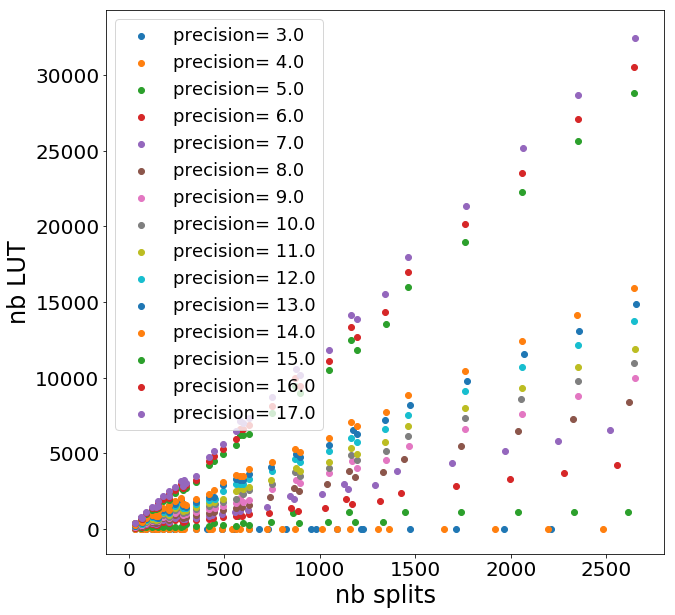

In [13]:

plt.figure(figsize=(10,10))
for prec in np.unique(results['precision']):
    plt.scatter(x=results[results['precision']==prec]['nb splits'], y=results[results['precision']==prec]['nb LUT'], label='precision= {}'.format(prec) )
plt.ylabel('nb LUT')
plt.xlabel('nb splits')
plt.legend()

## Nb Luts vs nb splits at a given precision for all tree depths

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


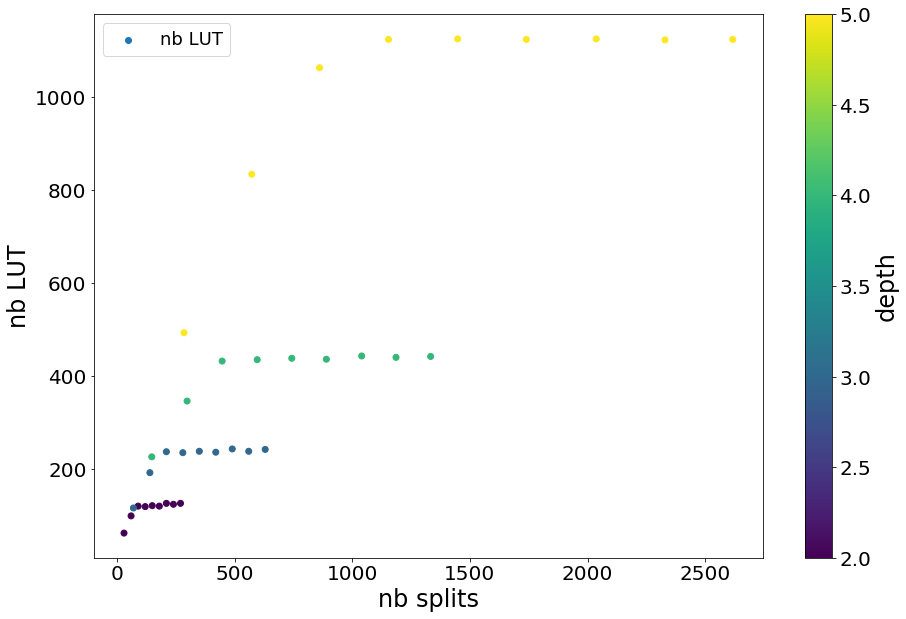

In [14]:
prec = 5

plt.figure(figsize=(15,10))
sub_df=results[(results['precision']==prec)  ]
plt.scatter(x=sub_df['nb splits'], y=sub_df['nb LUT'], c=sub_df['depth'] )
plt.ylabel('nb LUT')
plt.xlabel('nb splits')
#plt.xlim(0,500)
#plt.ylim(0,5000)
plt.colorbar(label='depth')
plt.legend()

sub_df['coeff']=sub_df['nb LUT']/sub_df['nb splits']

sub_df.groupby('depth')['coeff'].mean()
plt.savefig('comparison_thesis/proxy_{}bits.pdf'.format(prec), bbox_inches='tight')

In [15]:
#extract a coefficient nb of splits to LUT for each precision
results['coeff']=results['nb LUT']/results['nb splits']

results.groupby('precision')['coeff'].mean()

precision
3.0      0.018264
4.0      0.018016
5.0      0.879958
6.0      1.938150
7.0      2.646970
8.0      3.208793
9.0      3.785317
10.0     4.347656
11.0     4.774790
12.0     5.462628
13.0     5.917453
14.0     6.439911
15.0    10.300290
16.0    10.963400
17.0    11.664774
Name: coeff, dtype: float64

In [ ]:
table=pd.DataFrame(columns=['precision', 'depth', 'coef'])
results = results[~((results['precision']==5) & (results['rounds'] >40 ))]

    
for prec in np.unique(results['precision']):
    for depth in np.unique(results['depth']):
        x= results[(results['precision']==prec) & (results['depth']==depth)]['nb LUT']/results[(results['precision']==prec) & (results['depth']==depth)]['nb splits']
        print('prec = {}, depth = {}, coeff= {}'.format(prec, depth, x.mean()))
        table.loc[len(table)] = [prec, depth,x.mean()]

estimations=[]
for row in results.iterrows():
    coef=table.query('precision == {} & depth == {}'.format(row[1].precision, row[1].depth)  )['coef']
    estimations.append(round(coef.values[0] * row[1]['nb splits']))  
results['estimations']=estimations
results['error']=np.abs(results['nb LUT'] - results['estimations'])
results['relative error'] = results['error']/results['nb LUT']

groups=results.groupby(['precision', 'depth' ])

table['rel error']=groups['relative error'].mean().values
table['error']=groups['error'].mean().values
table.to_csv('conifer_table.csv')